In [36]:
# to convert this to index.html for slideshow on github, do this in shell:
# and add things if not already added to commit..
# !git commit -m "update slides index.ipynb"
!jupyter nbconvert --to slides index.ipynb
!mv index.slides.html index.html
!git add index.ipynb index.html
!git commit -m "update slides index.html"
!git push
# or use the sh script

[NbConvertApp] Converting notebook index.ipynb to slides
[NbConvertApp] Writing 296495 bytes to index.slides.html
[master 55462fd] update slides index.html
 2 files changed, 693 insertions(+), 589 deletions(-)
 rewrite docs/index.ipynb (84%)
Enumerating objects: 32, done.
Counting objects: 100% (32/32), done.
Delta compression using up to 8 threads
Compressing objects: 100% (27/27), done.
Writing objects: 100% (27/27), 5.33 MiB | 679.00 KiB/s, done.
Total 27 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To github.com:paultanger/CampsitePredict.git
   5e7e70e..55462fd  master -> master


# Let's use machine learning methods to detect and predict awesome undiscovered campsite locations!

This project stems out of my interest and interest of many outdoor enthusiasts to find amazing and undiscovered areas to go camping. There are several resources currently to locate interesting campsites, but they depend on users entering campsite information. What if we could scan satellite imagery and predict where good campsites will be? 

![alt text](slide_data/gunnison_site.jpg "cool campsite bro")

### Potential market and broader opportunities

The outdoor recreation market is quite large, here as a percent of GDP, and compared with other spending:

______________             |  ______________
:-------------------------:|:-------------------------:
<img src="slide_data/OutdoorRec_GDP.png" width="600" alt="rec % GDP"/> | <img src="slide_data/rec_bar_graph.png" width="600" alt="rec bar graph"/>

Beyond campsite prediction, these models could be used to identify safe areas in natural disasters and other applications

<section data-background-image='slide_data/ioverlander_page_overview.png'>

## Improved curation of iOverlander with machine learning approaches



### iOverlander: user contributed camping sites (and more)
This is a rich source of confirmed campsites we can use as training data.
In the US, it contains over 15,000 user entered points.
You can read more about this app and their mission here:
http://blog.ioverlander.com/about/about-ioverlander/

<img src="slide_data/ioverlander_web.png" width="800" alt="app screenshot">


<table><tr><td><img src='slide_data/overlander1.png'></td><td><img src='slide_data/overlander2.png'></td><td><img src='slide_data/example_campsite.png'></td></tr></table>
<center>Click the down arrow to explore this data</center>

In [7]:
# load the data 
import pandas as pd
wd = '../data/'
USdata = pd.read_csv(wd + 'iOverlander Places - United States - 2020-04-29.csv')
USdata.head(2)

,Location,Name,Category,Description,Latitude,Longitude,Altitude,Date verified,Open,Electricity,Wifi,Kitchen,Parking,Restaurant,Showers,Water,Toilets,Big rig friendly,Tent friendly,Pet friendly
0,"Borrego Salton Seaway, Borrego Springs, CA 920...",Anza Borrego - NICE,Wild Camping,Free Camping on Anza Borrego Park. Nice and wa...,33.280572,-116.146887,0.0,2019-01-28 00:00:00 UTC,Yes,Unknown,Unknown,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,"Borrego Salton Seaway, Borrego Springs, CA 920...",Arroyo Salado Camping,Established Campground,"Free with two vault toilets, nothing else exis...",33.280188,-116.145788,0.0,2020-02-16 14:20:45 UTC,Yes,No,No,No,NaN,No,No,No,Pit Toilets,Yes,Yes,Yes


Let's continue with the project overview (click to the right)

### For the first phase of this project, I have focused on two categories of data:

#### Established Campgrounds, and Wild Camping

<table><tr><td><img src='slide_data/est_camp_desc.png'></td><td><img src='slide_data/wild_camp_desc.png'></td></tr></table>

![alt text](slide_data/process.png "process overview")

## Some examples of the satellite images obtained through the Google Static Maps API:

![alt text](slide_data/example_sat_images1.png "example satellite images")
![alt text](slide_data/example_sat_images2.png "example satellite images")

## Can you tell the difference between these types of sites?

![alt text](slide_data/wild_vs_est_images.png "process overview")

![alt text](slide_data/CNN_process.png "CNN process overview")

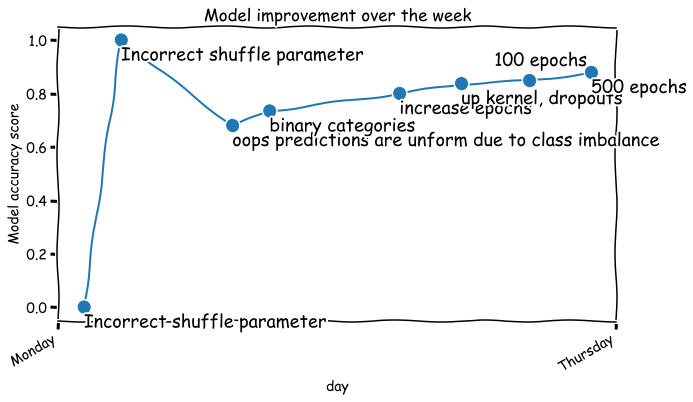

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

improvements = pd.read_csv('../data/model_improvements.csv')
improvements['pd_date'] = pd.to_datetime(improvements['combined'])
datetime_index = pd.DatetimeIndex(improvements['pd_date'])
improvements = improvements.set_index(datetime_index)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(improvements['pd_date'], improvements['Accuracy'], marker='o', markersize=12)
    ax.set_ylabel('Model accuracy score')
    ax.set_xlabel('day')
    days = mdates.WeekdayLocator(byweekday=(0))
    days_fmt = mdates.DateFormatter('%A')
    
    for i, (x , y) in enumerate(zip(improvements['pd_date'], improvements['Accuracy'])):

        label = improvements['Description'][i]
        if label == '100 epochs':
            # fix one point label
            plt.annotate('100 epochs', # this is the text
                     (pd.to_datetime('8/27/20 09:00:00'), 0.8484), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-35,15), # distance from text to points (x,y)
                     ha='left',
                    fontsize=18)
        else:
        # this method is called for each point
            plt.annotate(label, # this is the text
                         (x, y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,-20), # distance from text to points (x,y)
                         ha='left',
                        fontsize=18) # horizontal alignment can be left, right or center
    
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(days_fmt)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_minor_formatter(days_fmt)
    ax.xaxis.set_tick_params(which= 'both')
    ax.set_title('Model improvement over the week')
    fig.autofmt_xdate()
    plt.savefig('slide_data/model_improvement_plot.png')

### The two classes were imbalanced (data from the following states: AZ, CA, CO, OR, UT, WA:

|                        | Percent of data |
|------------------------|-----------------|
| Established Campground |       35 %      |
| Wild Camping           |       65 %      |

### The initial Convolutional Neural Network was trained in Keras and Tensorflow and various adjustments were made to the hyperparameters:

![alt text](slide_data/model_improvement_plot.png "model improvement")


### A plateau in model improvement was observed after several hundred epochs

![alt text](slide_data/500epochs_more_filters.png "500 epochs model validation")

### Model performance was impressive given how little curation of the satellite images were done.
<table><tr><td><img src='slide_data/conf_matrix_final.png' alt="confusion matrix"></td><td><img src='slide_data/ROC_500epochs.png' alt="ROC curve"></td></tr></table>

### Testing on unseen data from different states performed well, even the class imbalance was not as high as the training data (on the left, from ID, MT, NM; on the right, from just ID alone):

<table><tr><td><img src='slide_data/ROC_500epochs_newdata_ID_NM_MT.png' alt="confusion matrix"></td><td><img src='slide_data/ROC_500epochs_newdata_ID.png' alt="ROC curve"></td></tr></table>

## The next part of the project, I wanted to examine if I could improve the category labels using additional feature engineering, since I observed what seemed to be two sub classes in the "Wild Camping" category.

<table><tr><td><img src='slide_data/model_wrong1.png' alt="sat image of incorrect model prediction"></td><td><img src='slide_data/model_wrong2.png' alt="sat image of incorrect model prediction"></td><td><img src='slide_data/model_wrong3.png' alt="sat image of incorrect model prediction"></td></tr></table>

![alt text](slide_data/NLP_process.png "NLP process")

### Initial results with 3 K means clusters seems to split Wild Camping into two categories while the Established Campgrounds categories remains in the third cluster.  This is with data from the entire US (not just the states used in the CNN analysis).  The first column "Cluster name?" is my guess at what these clusters might represent.  Further exploration is in progress.

|       cluster name?      |             category            |     Percent of all sites in this cluster    |                                                                          top words                                                                        |
|:------------------------:|:-------------------------------:|:-------------------------------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------:|
|      roadside   spot     |          Wild   Camping         |                    73   %                   |     parking,   place, night, quiet, area, lot, nice, camping, park, free, good, overnight,   great, near, spot, street, big, just, view, river            |
|     wild   campground    |          Wild   Camping         |                    89   %                   |     road,   spot, forest, spots, dirt, nice, just, service, good, small, river, right,   camping, quiet, creek, site, camp, gravel, great, little         |
|      est   campground    |     Established   Campground    |                    95   %                   |     campground,   sites, water, nice, showers, park, night, lake, toilets, site, rv,   clean, free, tent, tables, pit, picnic, hot, camping, available    |

Next Steps:
    
* Clean training data
* Try sobel transformation
* Include additional binary columns such as “bathrooms” etc
* Utilize NLP topics to aid image classification
* Multiclassification
* Train with additional sat images
* Implement class weights
* NLP with higher level tokens than words
* Examine F1 scores
* More dropouts in model

## Thank you!

## Questions?